# Introduction

I attempt to predict income using the 1994 census bureau database dataset. The description of the variables can be found at 
Due to the size of the dataset, I don't have to consider computational overheard when choosing a machine learning algorithm. I will analyze the accuracy of 5 algorithms. Among those 5, I will choose 2 based on performance and create a seperate ensemble model. 

In [2]:
import pandas as pd
import numpy as np
import os 
import warnings
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline

In [3]:
train = pd.read_csv('MLadult/adult.data', sep=',\s', header=None)
test = pd.read_csv('MLadult/adult.test', sep=',\s', header=None)

In [4]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


In [5]:
train.columns = column_names
test.columns = column_names

# Exploratory Data Analysis (EDA)

In [6]:
original_nrows, orignal_ncols = train.shape
print("Data set has {} instances and {} features".format(original_nrows, orignal_ncols))

Data set has 32561 instances and 15 features


In [7]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Distribution of targets

Income <= 50K: 7841
Income > 50K: 24720


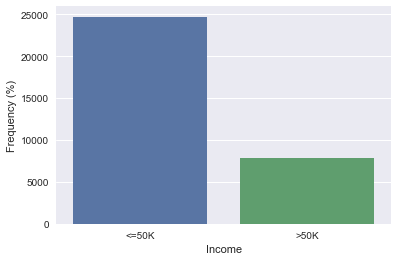

In [8]:
ax = sns.countplot(train['income'])
over, under = train['income'].value_counts()
plt.ylabel("Frequency (%)")
plt.xlabel("Income")
print("Income <= 50K: {}".format(under))
print("Income > 50K: {}".format(over))

The plot shows that the target is imbalanced. Tuning scale_pos_weight hyperparameter in XGBoost algorithm will adjust the model accordingly. 

Analyze distributions of the continuous/numerical variables.

In [9]:
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Feature scaling the numerical columns.

In [10]:
scaler = MinMaxScaler()
scaled_numeric_features_train = scaler.fit_transform(train[train.select_dtypes(exclude=['object']).columns])
df_scaled_numeric_features_train = pd.DataFrame(scaled_numeric_features_train, columns=train.select_dtypes(exclude=['object']).columns)
scaled_numeric_features_test = scaler.transform(test[test.select_dtypes(exclude=['object']).columns])
df_scaled_numeric_features_test = pd.DataFrame(scaled_numeric_features_test, columns=test.select_dtypes(exclude=['object']).columns)

In [11]:
train.update(df_scaled_numeric_features_train)
test.update(df_scaled_numeric_features_test)

In [12]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,State-gov,0.044302,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,0.048238,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States,<=50K
2,0.287671,Private,0.138113,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States,<=50K
3,0.493151,Private,0.151068,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States,<=50K
4,0.150685,Private,0.221488,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba,<=50K


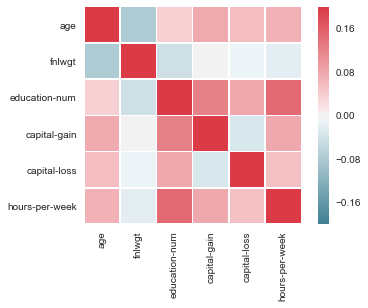

In [13]:
corr = train.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.2, center=0, square=True, linewidths=.5)
plt.show()

The numerical features all are correlated to each other except fnwgt. I will use correlation to variables "related" to the target variable y as a proxy for correlation to target variable y. If there was no correlation across the board for a numerical variable I will investigate the variable further and seek to remove the feature in the dataset. 

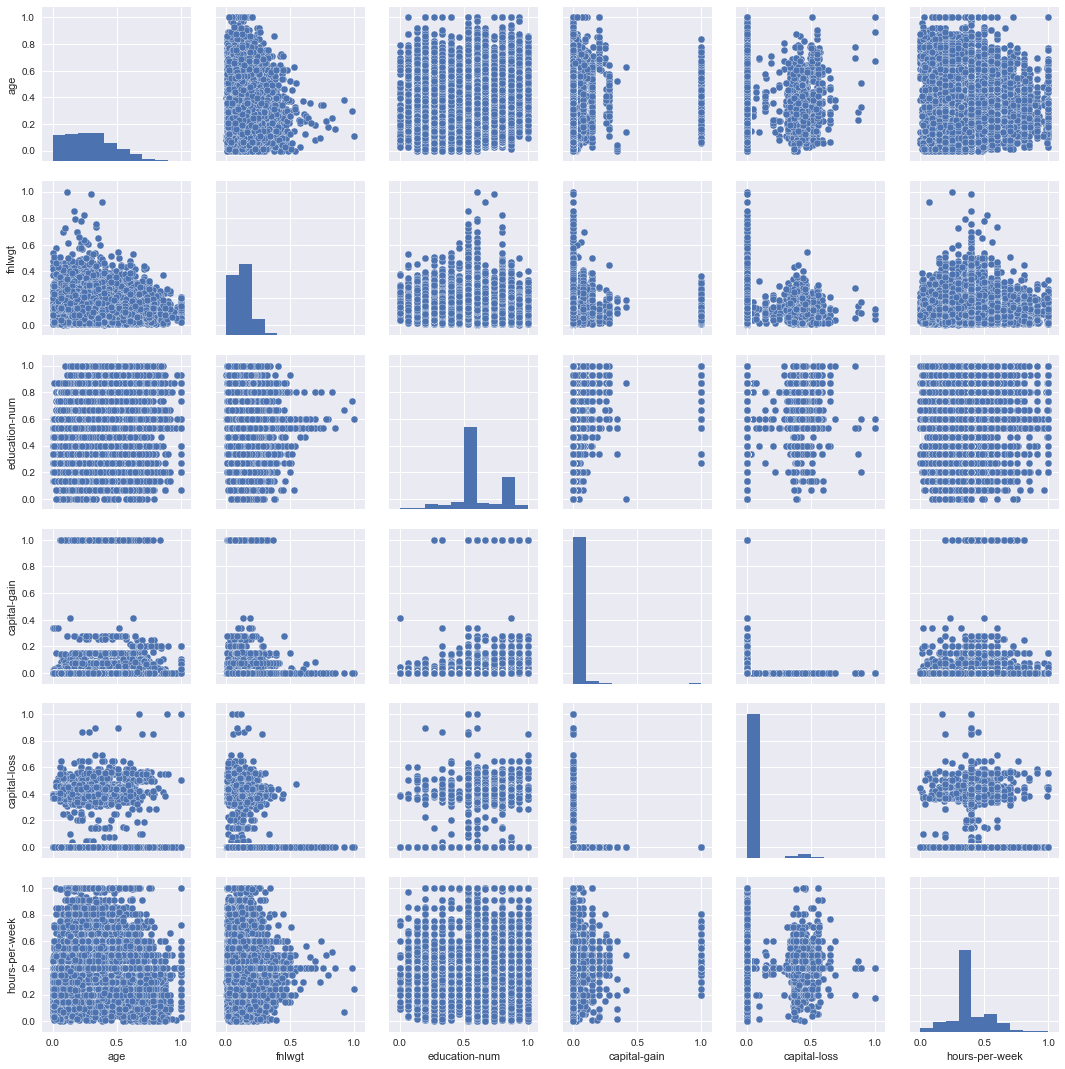

In [14]:
ax = sns.pairplot(df_scaled_numeric_features_train)

We can observe a fairly skewed distribution for the numeric features and fairly weak correlations among the other features.

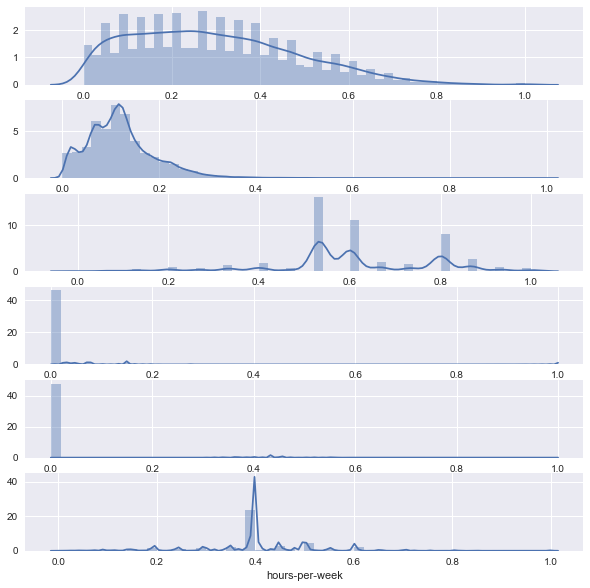

In [15]:
i = 1
plt.figure(figsize=(10,10))
for col in df_scaled_numeric_features_train.columns:
    plt.subplot(len(df_scaled_numeric_features_train.columns),1,i)
    sns.distplot(df_scaled_numeric_features_train[col])
    plt.xlabel(col)
    i = i + 1

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

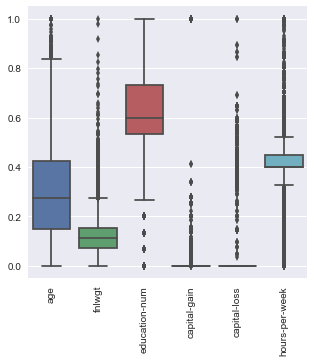

In [16]:
plt.figure(figsize=(5,5))
sns.boxplot(x=df_scaled_numeric_features_train[train.select_dtypes(exclude=['object']).columns])
plt.xticks(rotation=90)

Notice the extreme variability of values in capital-gain and capital-loss columns.

# Preprocessing

In [17]:
train[train.select_dtypes(exclude=['object']).columns]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0.301370,0.044302,0.800000,0.021740,0.000000,0.397959
1,0.452055,0.048238,0.800000,0.000000,0.000000,0.122449
2,0.287671,0.138113,0.533333,0.000000,0.000000,0.397959
3,0.493151,0.151068,0.400000,0.000000,0.000000,0.397959
4,0.150685,0.221488,0.800000,0.000000,0.000000,0.397959
5,0.273973,0.184932,0.866667,0.000000,0.000000,0.397959
6,0.438356,0.100448,0.266667,0.000000,0.000000,0.153061
7,0.479452,0.134036,0.533333,0.000000,0.000000,0.448980
8,0.191781,0.022749,0.866667,0.140841,0.000000,0.500000
9,0.342466,0.099947,0.800000,0.051781,0.000000,0.397959


First check dataset for null values.

In [18]:
print(train.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


Check data for abnormal/missing values in catagorical variables.

In [19]:
print(train['workclass'].value_counts())
print(train['occupation'].value_counts())

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64


There is value of '?' among one categorical column. Convert '?' into null.

In [20]:
train = train.replace('?', np.NaN)
test = test.replace('?', np.NaN)

In [21]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.shape

(30162, 15)

In [22]:
print ("Deleted {} percent of samples".format(float(original_nrows - train.shape[0])/float(original_nrows) * 100))

Deleted 7.367709836921471 percent of samples


In [23]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1:]
test_x = test.iloc[:,:-1]
test_y = test.iloc[:,-1:]

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
age               30162 non-null float64
workclass         30162 non-null object
fnlwgt            30162 non-null float64
education         30162 non-null object
education-num     30162 non-null float64
marital-status    30162 non-null object
occupation        30162 non-null object
relationship      30162 non-null object
race              30162 non-null object
sex               30162 non-null object
capital-gain      30162 non-null float64
capital-loss      30162 non-null float64
hours-per-week    30162 non-null float64
native-country    30162 non-null object
income            30162 non-null object
dtypes: float64(6), object(9)
memory usage: 3.7+ MB


Check if the columns are identical in train/test datasets.

In [25]:
cat_codes_dict = {"workclass": "Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked".split(sep=","),
              "education": "Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool".split(sep=","),
              "marital-status": "Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse".split(sep=","),
              "occupation": "Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces".split(sep=","),
              "relationship": "relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried".split(sep=","),
              "race": "White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black".split(sep=","),
              "sex": "Female, Male".split(sep=","),
              "native-country": "United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad, Peru, Hong, Holand-Netherlands".split(sep=",")
             }

Convert catagorical data using One Hot Encoding.

In [26]:
def categorical_features_encoder(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    noncategorical_cols = df.select_dtypes(exclude=['object']).columns
    onehotencode_col_values = pd.get_dummies(df[categorical_cols])
    modified_df = pd.concat([df[noncategorical_cols], onehotencode_col_values], axis=1)
    return modified_df

In [27]:
def label_encoder(df):
    le = LabelEncoder()
    return le.fit_transform(df)

In [28]:
train_x = categorical_features_encoder(train_x)
test_x = categorical_features_encoder(test_x)

In [29]:
train_y = label_encoder(train_y)
test_y = label_encoder(test_y)

Check if there are differences in features. If so, populate the column with 0s in a systematic way (since there is no instance of the category occuring in the test data). Having a mismatch of columns will be rejected by the evaluator. 

In [30]:
test_x[train_x.columns.difference(test_x.columns)[0]] = 0

In [31]:
test_x = test_x[train_x.columns]

# Modeling

I will analyze 5 classifiers and compare their mean accuracies by cross validation of k=10 folds.

In [32]:
RANDOM_STATE = 200
kfold = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE)
classifiers = [XGBClassifier(random_state=RANDOM_STATE),
              AdaBoostClassifier(random_state=RANDOM_STATE),
              RandomForestClassifier(random_state=RANDOM_STATE),
              LogisticRegression(random_state=RANDOM_STATE),
              SVC(random_state=RANDOM_STATE)]

classifier_names = ["XGBClassifier", "AdaBoostClassifier", "RandomForestClassifier", "LogisticRegression", "SVC"]
cv_values = []
for classifier in classifiers:
    cv_values.append(cross_val_score(classifier, train_x, train_y, cv=kfold))


In [33]:
cv_means = []
cv_stds = []

for cv_value in cv_values:
    cv_means.append(cv_value.mean())
    cv_stds.append(cv_value.std())
    
cv_results = pd.DataFrame({"Algorithm" : classifier_names, "cross_validation_means" : cv_means, "cross_validation_stds" : cv_stds})
print(cv_results)

                Algorithm  cross_validation_means  cross_validation_stds
0           XGBClassifier                0.860056               0.005448
1      AdaBoostClassifier                0.855813               0.006195
2  RandomForestClassifier                0.843678               0.006390
3      LogisticRegression                0.846397               0.006279
4                     SVC                0.831145               0.005606


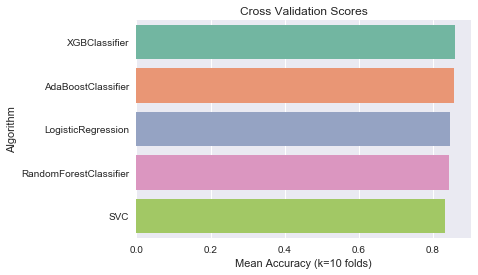

In [34]:
cv_results.sort_values(by="cross_validation_means", inplace=True, ascending=False)
sns.barplot("cross_validation_means", "Algorithm", data=cv_results, palette="Set2")
plt.xlabel("Mean Accuracy (k=10 folds)")
plt.title("Cross Validation Scores")
plt.show()

I will choose the top 2 performing classifiers (XGBClassifier, AdaBoostClassifier) to create my ensemble model. 

# Hyperparameter Tuning

Before creating an ensemble model, I will use GridSearch to find optimal hyperparameters for the 2 base models. Due to machine processing power limitations, I will reduce the folds and decrease the considered number of hyperparameter values.  

In [35]:
xgboost = XGBClassifier(random_state=RANDOM_STATE)

xgboost_param_grid = {"n_estimators": [100, 150, 200],
              "learning_rate": [0.01, 0.05, 0.10, 0.2],
              "subsample": [0.8, 0.9],
              "max_depth": [6, 8],
              "colsample_bytree": [0.7, 0.8, 0.9],
              'min_child_weight": [3, 4]
             }
gridsearch_xgboost = GridSearchCV(xgboost,param_grid = xgboost_param_grid, cv=StratifiedKFold(n_splits=3, random_state=RANDOM_STATE), scoring="accuracy", n_jobs= 4, verbose = 1)
gridsearch_xgboost.fit(train_x, train_y)
xgboost_best_estimator = gridsearch_xgboost.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 31.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 74.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 147.6min
[Parallel(n_jobs=4)]: Done 864 out of 864 | elapsed: 163.6min finished


AttributeError: 'XGBClassifier' object has no attribute 'best_score_'

In [40]:
print(gridsearch_xgboost.best_score_)

0.868775280153836


In [47]:
ada = AdaBoostClassifier(random_state=RANDOM_STATE)

ada_param_grid = {"n_estimators": [100, 150, 200],
              "learning_rate": [0.01, 0.05, 0.10, 0.2]}

grid_search_ada = GridSearchCV(ada, param_grid = ada_param_grid, cv=StratifiedKFold(n_splits=3, random_state=RANDOM_STATE), scoring="accuracy", n_jobs=2, verbose = 1)
grid_search_ada.fit(train_x, train_y)
ada_best_estimator = grid_search_ada.best_estimator_
print(grid_search_ada.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed:  2.4min finished


0.8561434918108879


# Ensemble Modeling

Voting classifier to combine predictions of models based on probability (soft voting). As I only chose 2 base models for the ensemble model, hard voting makes little sense.

In [52]:
ensemble_voting_model = VotingClassifier(estimators=[('ada',ada_best_estimator),('xgboost',xgboost_best_estimator)], voting='soft', n_jobs=4)
ensemble_voting_model = ensemble_voting_model.fit(train_x, train_y)

In [69]:
pred_testy = ensemble_voting_model.predict(test_x)
accuracy = accuracy_score(pred_testy, test_y)
print("Accuracy: {}".format(accuracy))
print(classification_report(test_y, pred_testy))

Accuracy: 0.8704515272244356
             precision    recall  f1-score   support

          0       0.89      0.94      0.92     11360
          1       0.78      0.65      0.71      3700

avg / total       0.87      0.87      0.87     15060

